cloudy thinking. come on.
ok. first we generate a graph from a phylo.tree

In [ ]:
from Bio import Phylo
from Layout import *

TreeOfLife=Phylo.from_newick('allofthespeciesever.newick')

treeLayout=Layout_from_Phylo(TreeOfLife)

Layout nodes know their position, direction(?),parent,children.whatever we need

now. for nodes in Layout: (list of nodes, breadth first.)
traverse the tree, drawing threads as we go.

In [ ]:
import Path as Path
for nodes in treeLayout.breadthfirst():
        p=Path(start=(node.parent.pos),start_dir=(node.parent.direc),end=(node.pos),end_dir=(node.direc))
        threads=thread_dict(node.parent)
        n_threads=node.num_terminals

i'm really struggling. fucking hell. maybe go for a walk or something.

break it down some more. lets say we have a path. draw some fucking threads along it.

In [276]:
int(3)

3

In [2]:
from vec2d import Vec2D
import svgwrite
from scipy.special import binom
import math
def m(p1,p2):
    #p1-p2
    return tuple(i-j for i,j in zip(p1,p2))
def bez_path(coefs):
    order=len(coefs)-1
    for i in range(len(coefs)):
        if type(coefs[i])!=Vec2D:
            coefs[i]=Vec2D(*coefs[i])
    def path(t):
        pathpoint=sum(binom(order,idx)*c*(1-t)**(order-idx)*t**idx for idx,c in enumerate(coefs))
        deriv=(order)*sum(binom(order-1,idx)*(coefs[idx+1]-coefs[idx])*(1-t)**(order-1-idx)*t**idx for idx in range(len(coefs)-1))
        return pathpoint,deriv
    return path
def bez_list_path(bezlist):
    subpaths=[bez_path(c) for c in bezlist]
    order=len(bezlist)
    def path(t):
        t=t*order#0->0,1/3->1, 1->3
        s,t=int(t),t-int(t)
        if s==order:
            s=order-1
            t=1
        return subpaths[s](t)
    return path
def path(t):
    def _(p):
        return (-p[0],-p[1])
    p0=(0,0)
    p1=(13,0)
    p2=(13,16)
    p3=(-3,15)
    p4=(-2,2.9)
    p5=(5.7,2.5)
    p6=(6,7)
    p7=(4.7,7.2)
    p8=(4.4,7.2)
    t=t*2-1
    if t<0:
        t=-t
        xy=_(bez((p0,p1,p2,p3,p4,p5,p6,p7,p8),t))
        deriv=bez((m(p1,p0),m(p2,p1),m(p3,p2),m(p4,p3),m(p5,p4),m(p6,p5),m(p7,p6),m(p8,p7)),t)
        deriv=(8*deriv[0],8*deriv[1])
    else:
        xy=bez((p0,p1,p2,p3,p4,p5,p6,p7,p8),t)
        deriv=bez((m(p1,p0),m(p2,p1),m(p3,p2),m(p4,p3),m(p5,p4),m(p6,p5),m(p7,p6),m(p8,p7)),t)
        deriv=(8*deriv[0],8*deriv[1])
    return xy,deriv
    
def render_threads_along_path(path,n_threads,diameter):
    g=svgwrite.container.Group()
    
coefs=[(0,0),(13,0),(13,16)]
p=bez_path(coefs)

In [172]:
points=[path(i)[0] for i in np.arange(0.2,0.32,0.02)]

dt=1/(len(points)-1)
A=[(t**3,t**2,t,1) for t in np.arange(0,1+dt,dt)]
B=[point.car for point in points]
X=np.linalg.lstsq(A,B)[0]
X=list(zip(*X))
M=[[-1,3,-3,1],\
   [3,-6,3,0],\
   [-3,3,0,0],\
   [1,0,0,0]]
pts=list(zip(*(np.linalg.solve(M,x) for x in X)))
pts
#[(points[idx],pts[0]*(1-i)**3+3*pts[1]*(1-i)**2*i+3*pts[2]*(1-i)*i**2+pts[3]*i**3) for idx,i in enumerate(np.arange(0,1+dt,dt))]


[(12.0, 4.7999999999999989),
 (14.0, 4.400000000000003),
 (16.000000000000007, 3.3999999999999977),
 (18.0, 1.8000000000000025)]

In [204]:
np.arange(3/50,4/50+1/50/5,1/50/5)
s=4
segs=[50]
i=0
SUBSEGS=5
ds=1/segs[i]/SUBSEGS
[(s-1)/segs[i]+k*ds for k in range(SUBSEGS+1)]

[0.06, 0.064, 0.068, 0.072, 0.076, 0.08]

In [387]:
from random import gauss,random,randrange,shuffle
from copy import copy,deepcopy
from noise import snoise2

def cubic_approx(points):
    dt=1/(len(points)-1)
    A=[(t**3,t**2,t,1) for t in [i/(len(points)-1) for i in range(len(points))]]
    B=[point.car for point in points]
    #should we constrain c0,c3?
    X=np.linalg.lstsq(A,B)[0]
    X=list(zip(*X))
    M=[[-1,3,-3,1],\
       [3,-6,3,0],\
       [-3,3,0,0],\
       [1,0,0,0]]
    return list(zip(*(np.linalg.solve(M,x) for x in X)))

def colerp(a,b,p):
    a=(a>>16,(a>>8)&0xff,a&0xff)
    b=(b>>16,(b>>8)&0xff,b&0xff)
    r=tuple(int(i+(j-i)*p+0.5) for i,j in zip(a,b))
    return (r[0]<<16)+(r[1]<<8)+r[2]
def render(path,segs):
    p=svgwrite.path.Path(fill='none',stroke='black',stroke_width=0.2)
    p.push(['M',path(0)[0].car])
    p.push(['C',(3/segs*path(0)[1]+path(0)[0]).car,(path(1/segs)[0]-3/segs*path(1/segs)[1]).car+(path(1/segs)[0]).car])
    for s in range(2,segs+1):
        p.push(['S',(path(s/segs)[0]-3/segs*path(s/segs)[1]).car+(path(s/segs)[0]).car])
    return p
def pathlength(path):
    #integral of sqrt(dx/ds^2+dy/ds^2)ds
    s=0
    
    for i in range(101):
        xy,deriv=path(i/100)
        s+=deriv.r/101
    return s
def bundle(path,n,diam,**kwargs):
    
    
    
    SEED=random()*10
    p_len=pathlength(path)
    xfreq=10
    yfreq=6
    octaves=1
    scale=1.3
    
    filt=kwargs.pop('filter',None)
    segs=[int(p_len)//2 for i in range(n)]
    threads=[]
    for i in range(n):
        threads.append([])
    normcoefs=[-diam/2+i*diam/n for i in range(n+1)]
    
    for i in range(n):
        SUBSEGS=5
        ds=1/segs[i]/SUBSEGS
        points=[]
        for j in [k*ds for k in range(SUBSEGS+1)]:
            p=path(j)
            norm=p[1]
            norm.rotate(math.pi/2)
            norm=norm*(1/norm.r)
            y=normcoefs[i]
            simplex=snoise2(SEED+j*p_len/xfreq,y/yfreq,octaves)*scale
            points.append(p[0]+(simplex+y)*norm)
        c0,c1,c2,c3=cubic_approx(points)
        threads[i].append(['M',c0,'C',c1,c2,c3])

        #norms1=[normvec*n for n in normcoefs]
    print('iterating...')
    for s in range(2,segs[i]+1):

        for i in range(n):        
            SUBSEGS=5
            ds=1/segs[i]/SUBSEGS
            points=[]
            for j in [(s-1)/segs[i]+k*ds for k in range(SUBSEGS+1)]:
                p=path(j)
                norm=p[1]
                norm.rotate(math.pi/2)
                norm=norm*(1/norm.r)
                y=normcoefs[i]
                simplex=snoise2(SEED+j*p_len/xfreq,y/yfreq,octaves)*scale
                points.append(p[0]+(simplex+y)*norm)

            c0,c1,c2,c3=cubic_approx(points)
            
            c0=threads[i][-1][5]
            c1=(2*Vec2D(*c0)+(-1)*Vec2D(*threads[i][-1][4])).car
            
            threads[i].append(['M',c0,'C',c1,c2,c3])


    #transpose array of segments
    #threads=[[seg0,seg1...segn],
    #         [seg0,seg1...segn],
    #         [seg0,seg1...segn]]
    #we want [[seg0, [seg1,  . [segn,
    #          seg0,  seg1,  .  segn,
    #          seg0], seg1], .  segn]]

    shuffle(threads)
    return_gp=svgwrite.container.Group()
    ''' for seglist in threads:
        #h=svgwrite.container.Group() 
        #for seg in seglist:
        if filt:
            gp=svgwrite.container.Group(filter=filt.get_funciri())
        else:
            gp=svgwrite.container.Group()
        grad=[]
        stcol=0x3c8db7
        endcol=0x296682
        stroke_width=1
        for j in range(10):
            p=svgwrite.path.Path(fill='none')
            for seg in seglist:
                p.push(seg)
            grad.append(p)
            grad[j].stroke(width=(10-j)/10*stroke_width,color='#'+hex(int(colerp(endcol,stcol,j/9)+0.5))[2:])
            gp.add(grad[j])
        #h.add(gp)
        g.add(gp)
    '''
    threads=list(zip(*threads))#transpose
    
    for seglist in threads:
        
        #choose two and swap them. frequency of swapping is proportional to p_len/segs
        seglist=list(seglist)
        numswaps=int(1.8*p_len/segs[0]+0.5)#proportional to length of segment
        for i in range(numswaps):
            def dist(a,b):
                p1=seglist[a][1]
                p2=seglist[b][1]
                return math.sqrt((p2[0]-p1[0])**2+(p2[1]-p2[1])**2)
            iterations=0
            a=randrange(len(seglist)-1)
            while dist(a,a+1)<1:#if the two segments intersect, pick again
                iterations+=1
                if iterations>len(seglist):
                    a=None
                    break
                a=randrange(len(seglist)-1)
            if a:
                seglist[a],seglist[a+1]=seglist[a+1],seglist[a]
                
        for segment in seglist:
            if filt:
                segment_gp=svgwrite.container.Group(filter=filt.get_funciri())
            else:
                segment_gp=svgwrite.container.Group()

            stcol=0x3c8db7
            endcol=0x296682
            stroke_width=1
            for j in range(10):
                p=svgwrite.path.Path(fill='none',stroke_linecap='butt')
                p.push(segment)
                p.stroke(width=(10-j)/10*stroke_width,color='#'+hex(int(colerp(endcol,stcol,j/9)+0.5))[2:])
                segment_gp.add(p)
                #if j==0:
                    #print(p.commands,segment)
            
            shadow_gp=svgwrite.container.Group()#filter=shadowfilt.get_funciri())
            for j in range(5):
                p=svgwrite.path.Path(fill='none',stroke_linecap='butt',style='stroke-opacity:'+str(j**2/45))
                p.push(segment)
                p.stroke(width=stroke_width*(1+(5-j)*0.1),color='#'+hex(int(colerp(0x0,stcol,0.3)))[2:])
                shadow_gp.add(p)
            return_gp.add(shadow_gp)
            return_gp.add(segment_gp)

    return return_gp


iterating...


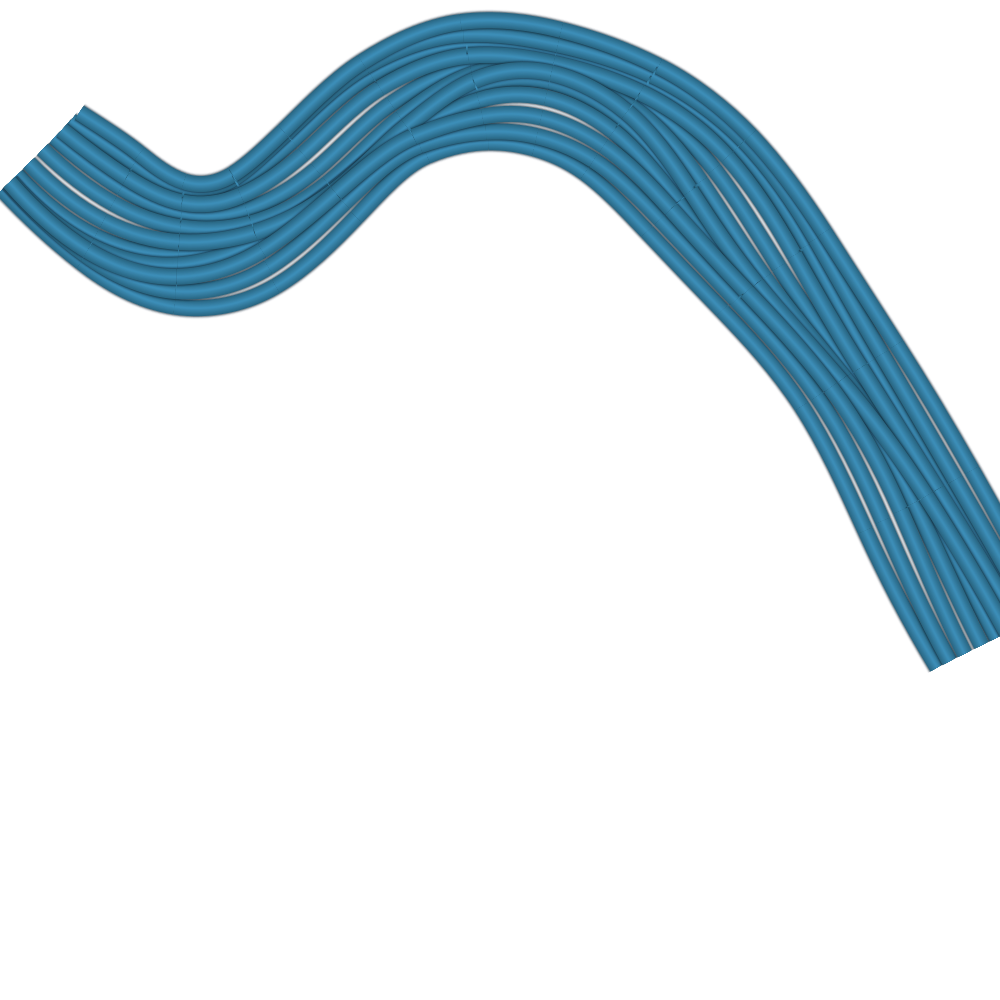

In [388]:
coefs=[(0,0),(13,0),(13,16),(-3,15),(-2,2.9),(5.7,2.5),(6,7),(4.7,7.2),(4.4,7.2)]
path=bez_list_path([[(0,0),(10,10),(20,0)],[(20,0),(30,-10),(40,0)],[(40,0),(50,10),(60,30)]])

dwg=svgwrite.Drawing(size=(1000,1000),debug=False)
#dwg['style']='background:#ccdddd'
threadgauss=dwg.defs.add(svgwrite.filters.Filter(x='-200%',y=-20,width='400%',height=40))
'''
threadgauss.feGaussianBlur(stdDeviation=0.04,result='res1')
threadgauss.feGaussianBlur(in_='res1',stdDeviation=0.04,result='res2')
'''
threadgauss.feMerge(['SourceGraphic'],result='res2')
threadgauss.feTurbulence(stitchTiles='stitch',type='fractalNoise',baseFrequency=1,numOctaves=8,result='noise')
threadgauss.feDisplacementMap(in_='res2',in2='noise',scale=0.4,xChannelSelector='R',yChannelSelector='G',result='res3')

threadgauss.feDisplacementMap(in_='res2',in2='noise',scale=3.1,xChannelSelector='G',yChannelSelector='B',result='res12')
threadgauss.feColorMatrix(in_='res12',result='res13',type='matrix',values=[1.4,0,0,0,0, 0,1.4,0,0,0, 0,0,1.4,0,0, 0,0,0,0.4,0])
threadgauss.feComposite(in_='res13',in2='res3',operator='atop',result='res14')

threadgauss.feComposite(in_='noise',in2='res3',operator='in',result='res4')
threadgauss.feColorMatrix(in_='res4',type='saturate',values=0.1,result='res5')
threadgauss.feBlend(in_='res5',in2='res3',mode='lighten',result='res6')

threadgauss.feComposite(in_='res6',in2='res14',operator='arithmetic', k1=0.1,k2=0.18,k3=0.82,result='yarn')


'''
threadgauss.feGaussianBlur(in_='yarn',stdDeviation=0.08,result='shadow')
threadgauss.feColorMatrix(in_='shadow',type='matrix',values=[0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,1.5,0], result='res7')
threadgauss.feColorMatrix(in_='yarn',type='luminanceToAlpha',result='res9')
threadgauss.feGaussianBlur(in_='res9',stdDeviation=0.15,result='res10')
threadgauss.feOffset(in_='res10',dx=0.2,dy=0.2,result='dropshadow')
comp=threadgauss.feComponentTransfer(in_='dropshadow',result='res11')
comp.feFuncA('linear',slope=0.9,intercept=0)'''

#threadgauss.feMerge(['res11','res7','res12','res8'])
#threadgauss.feMerge(['yarn'])

blur_it=dwg.defs.add(svgwrite.filters.Filter(x='-200%',y=-20,width='400%',height=40))
blur_it.feGaussianBlur(stdDeviation=0.02,result='blurres1')
blur_it.feGaussianBlur(in_='blurres1',stdDeviation=0.02,result='blurres2')
blur_it.feTurbulence(stitchTiles='stitch',type='fractalNoise',baseFrequency=1,numOctaves=3,result='blurnoise')
blur_it.feDisplacementMap(in_='blurres2',in2='blurnoise',scale=0.5,xChannelSelector='R',yChannelSelector='G',result='blurwobble')
blur_it.feComposite(in_='blurwobble',in2='blurres2',operator='arithmetic',k1=0.1,k2=0.4,k3=0.6)
g=bundle(path,12,8,filter=threadgauss)
g.scale(16)
g.translate((2,10))
g.attribs['filter']=blur_it.get_funciri()
dwg.add(g)
from IPython.display import SVG
import xml.etree.ElementTree as etree
x=dwg.get_xml()
filts=x.find('defs').findall('filter')
colmat=[]
for f in filts:
    colmat.extend(f.findall('feColorMatrix'))
for c in colmat:
    if c.attrib['type']=='matrix':
        #print('old values:',c.attrib['values'])
        c.attrib['values']=''.join(c.attrib['values'][1:-1].split(','))
        #print('converted to ',c.attrib['values'])
SVG(etree.tostring(x))

In [389]:
with open('/home/bwsq/Desktop/threadsample.svg','w') as f:
    f.write(str(etree.tostring(x))[2:-1])

In [355]:
paths=[x[1][i*24][0].attrib['d'] for i in range(10)]
paths[]

['M -1.5561778142734157 1.556177814273416 C 0.896816751954 3.4332587018 3.36056857691 4.52152066865 5.5807294425541905 5.2481763936145285',
 'M 5.5807294425541905 5.2481763936145285 C 7.8133385437 5.97182504774 9.9493264895 6.33015559175 12.268248145919207 6.141240729596029',
 'M 12.268248145919207 6.141240729596029 C 14.5477315214 5.94911952299 17.1735877002 5.43233757599 19.69244891579318 3.9155611447414644',
 'M 19.69244891579317 3.915561144741468 C 22.4176938541 2.14693865568 23.7786810059 0.202029009605 25.19448785185091 -1.209186913581819',
 'M 25.19448785185091 -1.209186913581819 C 26.5720261568 -2.70648876141 28.1594398548 -3.97512501017 30.0 -3.97329381108284',
 'M 30.0 -3.97329381108284 C 31.8600805708 -4.00947577846 33.3812781334 -2.59897295207 34.806339575747145 -1.2105659595785878',
 'M 34.806339575747145 -1.2105659595785878 C 36.2367823973 0.177218117991 38.1489830276 1.5833034974 40.45289196758137 3.506461847653286',
 'M 40.45289196758137 3.506461847653286 C 42.689662202

In [289]:
for i in d:
    for j in range(len(d[i])-1):
        if d[i][j][1]!=d[i][j+1][0]:
            a=d[i][j][1].split(',')
            b=d[i][j+1][0].split(',')
            a=(float(a[0][8:]),float(a[1][2:-1]))
            b=(float(b[0][8:]),float(b[1][2:-1]))
            print(i,j,math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2))

0 1 6.169484474161015e-15
0 6 1.888293221827313e-14
0 8 63.097818286068204
0 10 6.169484474161015e-15
0 15 1.888293221827313e-14
1 1 6.169484474161015e-15
1 6 1.888293221827313e-14
1 8 62.52586214856439
1 10 6.169484474161015e-15
1 15 1.888293221827313e-14
2 1 7.847321480213184e-15
2 6 1.888293221827313e-14
2 8 62.154240576471985
2 10 7.847321480213184e-15
2 15 1.888293221827313e-14
3 1 7.944109290391274e-15
3 6 1.888293221827313e-14
3 8 61.77693853539806
3 10 7.944109290391274e-15
3 15 1.888293221827313e-14
4 1 7.847321480213184e-15
4 6 1.7763568394002505e-14
4 8 61.08853100501103
4 10 7.847321480213184e-15
4 15 1.7763568394002505e-14
5 1 7.847321480213184e-15
5 6 1.888293221827313e-14
5 8 60.13896999276516
5 10 7.847321480213184e-15
5 15 1.888293221827313e-14
6 1 7.895083119518377e-15
6 6 1.888293221827313e-14
6 8 59.31816863876235
6 10 7.895083119518377e-15
6 15 1.888293221827313e-14
7 1 7.847321480213184e-15
7 6 1.888293221827313e-14
7 8 58.95673406681504
7 10 7.847321480213184e-15

In [278]:
len(d[0])

18

In [253]:
dwg=svgwrite.Drawing()
p=dwg.path(fill='none',stroke='blue',stroke_width=3,style="stroke-opacity:0.4")
p.push(['M',100,100,'C',200,100,200,300,400,300])
dwg.add(dwg.rect(50,50,100,))
dwg.add(p)
SVG(dwg.tostring())

In [230]:
snoise2(0,1/5,1)


0.005765710957348347

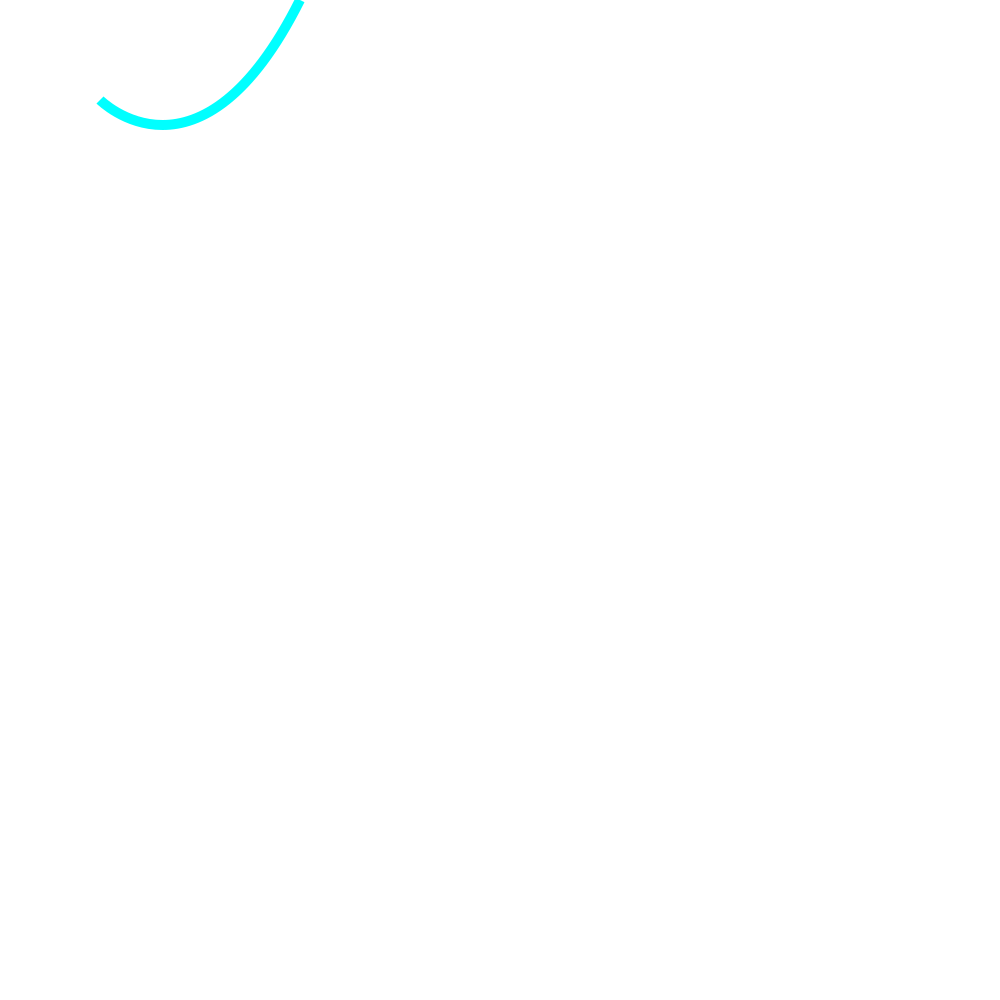

In [243]:
dwg=svgwrite.Drawing(size=(1000,1000),debug=False)
threadgauss=dwg.defs.add(svgwrite.filters.Filter())
threadgauss.feGaussianBlur(stdDeviation=0.004,result='res1')
threadgauss.feGaussianBlur(in_='res1',stdDeviation=0.004,result='res2')
threadgauss.feTurbulence(baseFrequency=0.01,numOctaves=3,result='noise')
threadgauss.feDisplacementMap(in_='res2',in2='noise',scale=10,xChannelSelector='R',yChannelSelector='G',result='res3')
threadgauss.feGaussianBlur(in_='res3',stdDeviation=2,result='res4')
threadgauss.feColorMatrix(in_='res4',type='matrix',values=[0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,1,0])
dwg.add(dwg.path(fill='none',stroke='aqua',stroke_width=10,filter=threadgauss.get_funciri()))

dwg.elements[1].push(['M',(100,100),'s',(100,100,200,-100)])
import xml.etree.ElementTree as etree
x=dwg.get_xml()
filts=x.find('defs').findall('filter')
colmat=[]
for f in filts:
    colmat.extend(f.findall('feColorMatrix'))
for c in colmat:
    c.attrib['values']=''.join(c.attrib['values'][1:-1].split(','))
SVG(etree.tostring(x))

In [64]:
dwg.elements[1].elements[0].elements[0].attribs

{'d': 'M 1.9448518260193173 -1.9448518260193175 C 2.3056152543452315 -2.1863850703526357 2.601504433106043 -0.5934684435547826 3.104109917246849 -1.035761269598692 C 3.1524425604117123 -0.9932285436136121 4.25981688103559 -0.3721881179884259 4.326497962085812 -0.422865739586594 C 4.387826529339514 -0.3762560284737805 5.480800507391214 -0.041959013043391995 5.540646816599474 -0.08026065093667833 C 5.609397715724595 -0.03626007549660106 6.630908924458554 0.059327434421475506 6.679155648200711 0.03423913807555401 C 6.745239888562968 0.06860294306392765 7.652389660394243 0.0015178333534470768 7.684536334518505 -0.011340836296257706 C 7.73484592931928 0.008783001624052541 8.514446140615627 -0.12865908846463078 8.527269929845735 -0.13224974944906087 C 8.559448321098362 -0.12323979989832554 9.216316699880629 -0.24907119931509555 9.219451646524499 -0.24957279077811467 C 9.301698357249435 -0.23641331706212487 9.745673428664256 -0.3335679624704453 9.81313065005304 -0.33626625132599663 C 9.066345

In [216]:
import xml.etree.ElementTree as etree
etree.tostring(x)

b'<svg baseProfile="full" height="1000" version="1.1" width="1000" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs><filter id="id101"><feGaussianBlur in="SourceGraphic" result="res1" stdDeviation="0.004" /><feGaussianBlur in="res1" result="res2" stdDeviation="0.004" /><feTurbulence baseFrequency="0.01" numOctaves="3" result="noise" /><feDisplacementMap in="res2" in2="noise" result="res3" scale="10" xChannelSelector="R" yChannelSelector="G" /><feGaussianBlur in="res3" result="res4" stdDeviation="0.002" /><feColorMatrix in="res4" type="matrix" values="[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]" /></filter></defs><path d="M 100 100 s 100 100 200 -100" fill="none" filter="url(#id101)" stroke="aqua" stroke-width="10" /></svg>'

In [6]:
from noise import snoise2
noises=[]
for x in range(256):

        noises.append(snoise2(x/0.1,y/0.1))
max(noises),min(noises)

(0.9978896975517273, -0.9978896379470825)

In [20]:
import svgwrite
g=svgwrite.container.Group(id='textpath')
g2=svgwrite.container.Group(id='prettypath')
p=svgwrite.path.Path(id='prettypath')
p1=svgwrite.path.Path()
g2.add(p)
g2.add(p1)

In [23]:
p=next(p for p in g2.elements if p.get_id()=='prettypath')

In [25]:
next(i for i in range(10) if i==8)

8